In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool, contextual_search
tools = [tavily_search, think_tool, contextual_search]

### Verify Contextual Tool

In [3]:
# Test contextual_search tool
print("Testing contextual_search tool...")
print("=" * 80)

# Test with a sample query (adjust based on your knowledge base)
test_query = "what is microsofts revenue?"
print(f"\nQuery: {test_query}\n")

try:
    result = contextual_search.invoke({"query": test_query, "max_results": 5})
    print(result)
    print("\n" + "=" * 80)
    print("✅ contextual_search tool is working!")
except Exception as e:
    print(f"\n❌ Error testing contextual_search: {e}")
    print("\nMake sure you have:")
    print("1. CONTEXTUAL_AI_API_KEY set in your .env file")
    print("2. CONTEXTUAL_AI_AGENT_ID set in your .env file")
    print("3. The 'contextual' package installed: pip install contextual")


Testing contextual_search tool...

Query: what is microsofts revenue?

🔍 Found 5 result(s) for 'what is microsofts revenue?' in ContextualAI knowledge base:

## msft_10q_fy2024q1
**Attribution:** Context ID: 90257057-e8c4-befe-aeaf-dd477d3c9ba3 | Doc ID: a178298f-e14b-49bc-94af-42cc2a188699 | Page: 32 | Score: 0.9829

Filename: Microsoft 10-Q FY2024 Q1
Section: PART I
Sub-Section: ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL  CONDITION AND RESUL TS OF OPERATIONS
Sub-Sub-Section: OVERVIEW
Microsoft is a technology company whose mission is to empower every person and every organization on  the planet to achieve more. We strive to create local opportunity, growth, and impact in every country  around the world. We are creating the platforms and tools, powered by artificial intelligence (“AI”), that  deliver better, faster, and more effective solutions to support small and large business competitiveness,  improve educational and health outcomes, grow public-sector efficiency, a

In [4]:
# Optional: Inspect raw ContextualAI response structure
# This helps you understand what data is available
import os
from contextual import ContextualAI

api_key = os.getenv("CONTEXTUAL_AI_API_KEY")
agent_id = os.getenv("CONTEXTUAL_AI_AGENT_ID")

if api_key and agent_id:
    client = ContextualAI(api_key=api_key)
    
    # Get raw response WITH content text included
    query_result = client.agents.query.create(
        agent_id=agent_id,
        messages=[{"content": "what is microsofts revenue?", "role": "user"}],
        retrievals_only=True,
        include_retrieval_content_text=True  # This is the key parameter!
    )
    
    print("Raw QueryResponse structure:")
    print(f"Conversation ID: {query_result.conversation_id}")
    print(f"Number of retrieval contents: {len(query_result.retrieval_contents)}")
    print("\n" + "=" * 80)
    
    # Show first result details
    if query_result.retrieval_contents:
        first_result = query_result.retrieval_contents[0]
        print("\nFirst result structure:")
        print(f"  - doc_name: {getattr(first_result, 'doc_name', 'N/A')}")
        print(f"  - content_id: {getattr(first_result, 'content_id', 'N/A')}")
        print(f"  - doc_id: {getattr(first_result, 'doc_id', 'N/A')}")
        print(f"  - page: {getattr(first_result, 'page', 'N/A')}")
        print(f"  - format: {getattr(first_result, 'format', 'N/A')}")
        print(f"  - score: {getattr(first_result, 'score', 'N/A')}")
        print(f"  - content_text available: {getattr(first_result, 'content_text', None) is not None}")
        if hasattr(first_result, 'content_text') and first_result.content_text:
            print(f"\n  - content_text preview (first 300 chars):")
            print(f"    {first_result.content_text[:300]}...")
        else:
            print(f"\n  ⚠️  content_text is None or empty")
            print(f"  Make sure you're using include_retrieval_content_text=True in the query!")
else:
    print("⚠️  ContextualAI credentials not found. Skipping raw response inspection.")


Raw QueryResponse structure:
Conversation ID: e7f8374e-7fc3-446b-b552-238f41767a1e
Number of retrieval contents: 15


First result structure:
  - doc_name: msft_10q_fy2024q1
  - content_id: 90257057-e8c4-befe-aeaf-dd477d3c9ba3
  - doc_id: a178298f-e14b-49bc-94af-42cc2a188699
  - page: 32
  - format: pdf
  - score: 0.9829475932644243
  - content_text available: True

  - content_text preview (first 300 chars):
    Filename: Microsoft 10-Q FY2024 Q1
Section: PART I
Sub-Section: ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL  CONDITION AND RESUL TS OF OPERATIONS
Sub-Sub-Section: OVERVIEW
Microsoft is a technology company whose mission is to empower every person and every organization on  the planet t...


## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [5]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [6]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  3. **contextual_search**: For conducting RAG-based document search on historical market data, such as 10ks,    │
│  10q, etc.                                                                                                      │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  6. **Favor using contextual_search over tavily_search except for latest news in 2025**                         │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maxim

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [7]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [contextual_search, tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [8]:
# Limits
max_concurrent_research_units = 5
max_researcher_iterations = 2

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the plan**: Immediately after creating todos, use read_todos() to get the todo list, then use        │
│  write_file() to save it to `/research_plan.md` with a clear format showing all tasks and their status          │
│  3. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  4. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  5. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  6. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  7. **Update plan**: Before finishing, use read_todos() again and update `/research_plan.md` with the final     │
│  todo status to show completion                                                                                 │
│  8. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Saving Research Plan                                                                                        │
│  When saving the research plan to `/research_plan.md`, format it clearly:                                       │
│  - Include the original research question at the top                                                            │
│  - List all todos with their status (pending, in_progress, completed)                                           │
│  - Show the research strategy and delegation plan                                                               │
│  - Update the file at the end to reflect final completion status                                                │
│                                                                                                                 │
│  ## Report Writing Guidelines                         

### Create the agent

Now, we create our deepagent with these components. 

In [9]:
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model
#from langchain_google_genai import ChatGoogleGenerativeAI

# Model Gemini 3 
#model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

# Model Claude 4.5
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

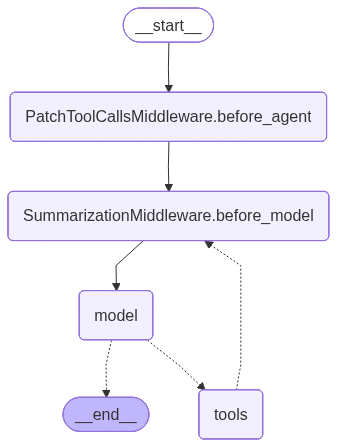

In [10]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
simple_query = "Based on NVIDIA's past performance, what is their best strategy for the future?"
complex_query = '''
I need a reality check on NVIDIA's three biggest bets: Automotive, Data Center, and Sovereign AI.
For each of these three sectors, can you compare what NVIDIA claims in their official documents (their stated strategy and risks) against what is actually happening in the market right now?
I'm specifically looking for a 'Fact vs. Reality' analysis: does recent news and competitor activity (like from AMD or Huawei) validate their internal confidence, or are there cracks in the narrative?
'''

In [12]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": complex_query,
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I need a reality check on NVIDIA's three biggest bets: Automotive, Data Center, and Sovereign AI.               │
│ For each of these three sectors, can you compare what NVIDIA claims in their official documents (their stated   │
│ strategy and risks) against what is actually happening in the market right now?                                 │
│ I'm specifically looking for a 'Fact vs. Reality' analysis: does recent news and competitor activity (like from │
│ AMD or Huawei) validate their internal confidence, or are there cracks in the narrative?                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll conduct a comprehensive "Fact vs. Reality" analysis of NVIDIA's three biggest bets. Let me break this down │
│ into a structured research plan and delegate to specialized sub-agents.                                         │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request and create research plan document",                                     │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Automotive sector from investor documents, │
│ earnings calls, and official statements",                                                                       │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Data Center sector from investor           │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Sovereign AI sector from investor          │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Automotive: recent news, competitor activity (AMD,        │
│ Huawei, others), actual adoption, challenges",                                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Data Center: recent news, competitor activity (AMD,       │
│ custom chips), actual market dynamics, challenges",                                                             │
│       "status": "pending"                               

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request and create research plan document', 'status':          │
│ 'in_progress'}, {'content': "Research NVIDIA's official claims and strategy for Automotive sector from investor │
│ documents, earnings calls, and official statements", 'status': 'pending'}, {'content': "Research NVIDIA's       │
│ official claims and strategy for Data Center sector from investor documents, earnings calls, and official       │
│ statements", 'status': 'pending'}, {'content': "Research NVIDIA's official claims and strategy for Sovereign AI │
│ sector from investor documents, earnings calls, and official statements", 'status': 'pending'}, {'content':     │
│ 'Research current market reality for Automotive: recent news, competitor activity (AMD, Huawei, others), actual │
│ adoption, challenges', 'status': 'pending'}, {'content': 'Research current market reality for Data Center:      │
│ recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges', 'status':            │
│ 'pending'}, {'content': 'Research current market reality for Sovereign AI: recent news, geopolitical            │
│ developments, competitor activity, actual government adoption', 'status': 'pending'}, {'content': 'Synthesize   │
│ findings and write comprehensive Fact vs. Reality report with consolidated citations', 'status': 'pending'},    │
│ {'content': 'Update research plan with final completion status', 'status': 'pending'}]                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "# Research Request\n\n## Objective\nReality check on NVIDIA's three biggest bets: Automotive,     │
│ Data Center, and Sovereign AI.\n\n## Requirements\nFor each of these three sectors:\n1. Compare what NVIDIA     │
│ claims in their official documents (stated strategy and risks)\n2. Against what is actually happening in the    │
│ market right now\n3. Provide 'Fact vs. Reality' analysis\n4. Assess whether recent news and competitor activity │
│ (AMD, Huawei, others) validates their internal confidence\n5. Identify any cracks in the narrative\n\n##        │
│ Deliverable Format\n- Fact vs. Reality comparison for each sector\n- Analysis of official claims vs. market     │
│ reality\n- Competitor activity assessment\n- Validation or contradiction of NVIDIA's confidence\n"              │
│ }                                                                                                               │
│    ID: toolu_01BKwgXJnK5CxMpKrYMir3Ja                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_plan.md",                                                                             │
│   "content": "# Research Plan: NVIDIA's Three Biggest Bets - Fact vs. Reality\n\n## Research Question\nReality  │
│ check on NVIDIA's three biggest bets (Automotive, Data Center, Sovereign AI): comparing official claims against │
│ market reality and competitor activity.\n\n## Research Strategy\nDelegate to 6 parallel sub-agents to           │
│ research:\n1. NVIDIA's official claims for each sector (3 sub-agents)\n2. Current market reality for each       │
│ sector (3 sub-agents)\n\nThen synthesize findings into comprehensive Fact vs. Reality analysis.\n\n## Task      │
│ List\n\n### \u2713 Planning Phase\n- [IN PROGRESS] Save research request and create research plan               │
│ document\n\n### \u23f3 Research Phase - Official Claims\n- [PENDING] Research NVIDIA's official claims and      │
│ strategy for Automotive sector from investor documents, earnings calls, and official statements\n- [PENDING]    │
│ Research NVIDIA's official claims and strategy for Data Center sector from investor documents, earnings calls,  │
│ and official statements\n- [PENDING] Research NVIDIA's official claims and strategy for Sovereign AI sector     │
│ from investor documents, earnings calls, and official statements\n\n### \u23f3 Research Phase - Market          │
│ Reality\n- [PENDING] Research current market reality for Automotive: recent news, competitor activity (AMD,     │
│ Huawei, others), actual adoption, challenges\n- [PENDING] Research current market reality for Data Center:      │
│ recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges\n- [PENDING] Research  │
│ current market reality for Sovereign AI: recent news, geopolitical developments, competitor activity, actual    │
│ government adoption\n\n### \u23f3 Synthesis Phase\n- [PENDING] Synthesize findings and write comprehensive Fact │
│ vs. Reality report with consolidated citations\n- [PENDIN

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_plan.md                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request and create research plan document",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Automotive sector from investor documents, │
│ earnings calls, and official statements",                                                                       │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Data Center sector from investor           │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Sovereign AI sector from investor          │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Automotive: recent news, competitor activity (AMD,        │
│ Huawei, others), actual adoption, challenges",                                                                  │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Data Center: recent news, competitor activity (AMD,       │
│ custom chips), actual market dynamics, challenges",                                                             │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                   

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request and create research plan document', 'status':          │
│ 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Automotive sector from investor   │
│ documents, earnings calls, and official statements", 'status': 'in_progress'}, {'content': "Research NVIDIA's   │
│ official claims and strategy for Data Center sector from investor documents, earnings calls, and official       │
│ statements", 'status': 'in_progress'}, {'content': "Research NVIDIA's official claims and strategy for          │
│ Sovereign AI sector from investor documents, earnings calls, and official statements", 'status':                │
│ 'in_progress'}, {'content': 'Research current market reality for Automotive: recent news, competitor activity   │
│ (AMD, Huawei, others), actual adoption, challenges', 'status': 'in_progress'}, {'content': 'Research current    │
│ market reality for Data Center: recent news, competitor activity (AMD, custom chips), actual market dynamics,   │
│ challenges', 'status': 'in_progress'}, {'content': 'Research current market reality for Sovereign AI: recent    │
│ news, geopolitical developments, competitor activity, actual government adoption', 'status': 'pending'},        │
│ {'content': 'Synthesize findings and write comprehensive Fact vs. Reality report with consolidated citations',  │
│ 'status': 'pending'}, {'content': 'Update research plan with final completion status', 'status': 'pending'}]    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me delegate the research to specialized sub-agents. I'll start with 5 parallel sub-agents (the maximum  │
│ per iteration):                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research NVIDIA's official claims, strategy, and stated risks for their AUTOMOTIVE            │
│ sector.\n\nYour task is to find and analyze NVIDIA's official statements from:\n- Recent investor presentations │
│ and earnings calls (2023-2024)\n- Annual reports (10-K) and quarterly reports (10-Q)\n- Official press releases │
│ and blog posts\n- Investor relations materials\n\nFocus on:\n1. Their stated automotive strategy and vision\n2. │
│ Revenue projections and growth expectations for automotive\n3. Key products and platforms (DRIVE platform,      │
│ partnerships)\n4. Stated risks and challenges they acknowledge\n5. Their confidence level and timeline for      │
│ automotive success\n6. Specific claims about market position and competitive advantages\n\nReturn a             │
│ comprehensive report with:\n- Direct quotes from official documents where possible\n- Specific revenue figures  │
│ and projections\n- Timeline expectations\n- All sources with full URLs for citation\n\nThis is for a \"Fact vs. │
│ Reality\" analysis, so I need their official narrative clearly documented."                                     │
│ }                                                                                                               │
│    ID: toolu_01Q5VP6ghFSPp2A2gEmVwTSF                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research NVIDIA's official claims, strategy, and stated risks for their DATA CENTER           │
│ sector.\n\nYour task is to find and analyze NVIDIA's official statements from:\n- Recent investor presentations │
│ and earnings calls (2023-2024)\n- Annual reports (10-K) and quarterly reports (10-Q)\n- Official press releases │
│ and blog posts\n- Investor relations materials\n\nFocus on:\n1. Their stated data center strategy and vision    │
│ (AI training, inference, cloud partnerships)\n2. Revenue figures and growth expectations\n3. Key products       │
│ (H100, H200, Grace Hopper, etc.)\n4. Stated risks and challenges they acknowledge (competition, supply chain,   │
│ customer concentration)\n5. Their confidence level about maintaining market dominance\n6. Specific claims about │
│ competitive moats and advantages\n\nReturn a comprehensive report with:\n- Direct quotes from official          │
│ documents where possible\n- Specific revenue figures and market share claims\n- Acknowledged competitive        │
│ threats\n- All sources with full URLs for citation\n\nThis is for a \"Fact vs. Reality\" analysis, so I need    │
│ their official narrative clearly documented."                                                                   │
│ }                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Perfect! Now I have comprehensive data. Let me compile the complete report with all the official claims,        │
│ revenue figures, and stated risks.                                                                              │
│                                                                                                                 │
│ ## NVIDIA Automotive Sector: Official Claims, Strategy, and Stated Risks - Comprehensive Report                 │
│                                                                                                                 │
│ Based on official NVIDIA documents including 10-K annual reports, 10-Q quarterly reports, earnings releases,    │
│ and investor relations materials from fiscal years 2022-2024.                                                   │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. STATED AUTOMOTIVE STRATEGY AND VISION                                                                     │
│                                                                                                                 │
│ ### Core Strategy Statement                                                                                     │
│                                                                                                                 │
│ NVIDIA positions automotive as one of four "large markets" where their expertise is critical, alongside Data    │
│ Center, Gaming, and Professional Visualization [1]. Their official strategy centers on:                         │
│                                                                                                                 │
│ **End-to-End AI Solution**: "Leveraging our technology leadership in AI and building on our long-standing       │
│ automotive relationships, we are delivering a complete end-to-end solution for the AV market under the DRIVE    │
│ Hyperion brand" [2].                                                                                            │
│                                                                                                                 │
│ **Dual AI Applications**: "NVIDIA has demonstrated multiple applications of AI within the car: AI can drive the │
│ car itself as a pilot in fully autonomous mode or it can also be a co-pilot, assisting the human driver while   │
│ creating a safer driving experience" [2].                                                                       │
│                                                                                                                 │
│ ### Market Composition                                                                                          │
│                                                                                                                 │
│ NVIDIA officially defines their automotive market as comprising:                                                │
│ - Autonomous vehicle (AV) platforms                                                                             │
│ - AI cockpit solutions                                                                                          │
│ - Electric vehicle computing platforms                                                                          │
│ - Infotainment platform solutions [2]                                                                           │
│                                                                                                                 │
│ ---                                                    

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research of NVIDIA's official SEC filings (10-K and 10-Q reports from FY2023-FY2024), │
│ I've compiled a detailed analysis of their official claims, strategy, and stated risks for the data center      │
│ sector.                                                                                                         │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## NVIDIA DATA CENTER: OFFICIAL CLAIMS, STRATEGY & STATED RISKS                                                 │
│                                                                                                                 │
│ ### 1. REVENUE FIGURES & GROWTH TRAJECTORY                                                                      │
│                                                                                                                 │
│ **Fiscal Year 2024 Performance (ended January 28, 2024):**                                                      │
│ - **Data Center Revenue: $47.5 billion, up 217% from FY2023** [1]                                               │
│ - Compute & Networking segment: $47.4 billion, up 215% year-over-year [1]                                       │
│ - Data Center represented approximately 78% of total company revenue in FY2024                                  │
│                                                                                                                 │
│ **Quarterly Momentum:**                                                                                         │
│ - Q1 FY2024: $4.28 billion (up 14% YoY) [2]                                                                     │
│ - Q2 FY2024: $10.32 billion (up 171% YoY) [3]                                                                   │
│ - Q3 FY2024: Data Center compute grew 324% YoY, with Hopper architecture driving growth [4]                     │
│                                                                                                                 │
│ **Official Statement on Growth Drivers:**                                                                       │
│ > "Strong sales of the NVIDIA HGX platform were driven by global demand for the training and inferencing of     │
│ large language models, recommendation engines, and generative AI applications." [4]                             │
│                                                                                                                 │
│ ### 2. DATA CENTER STRATEGY & VISION                                                                            │
│                                                                                                                 │
│ **A. Full-Stack Computing Platform Approach**                                                                   │
│                                                                                                                 │
│ NVIDIA positions itself as a "full-stack computing infrastructure company with data-center-scale offerings"     │
│ [1]. Their official strategy statement:                                                                         │
│                                                                                                                 │
│ > "Our full-stack includes the foundational CUDA programming model that runs on all NVIDIA GPUs, as well as     │
│ hundreds of domain-specific software libraries, software development kits, or SDKs, and Application Programming │
│ Interfaces, or APIs." [1]                              

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research of NVIDIA's official documents and statements, here is a detailed report on  │
│ their Sovereign AI sector claims, strategy, and stated risks:                                                   │
│                                                                                                                 │
│ ## NVIDIA's Official Sovereign AI Strategy: Comprehensive Analysis                                              │
│                                                                                                                 │
│ ### 1. NVIDIA's Official Definition of Sovereign AI                                                             │
│                                                                                                                 │
│ **Direct Definition from NVIDIA:**                                                                              │
│ "Sovereign AI refers to a nation's domestic capability to produce artificial intelligence using its own         │
│ infrastructure, data, workforce, and business networks. The goal is to protect and preserve local languages,    │
│ values, culture, and history." [1]                                                                              │
│                                                                                                                 │
│ **Strategic Framing:**                                                                                          │
│ NVIDIA positions sovereign AI as a "global policy imperative to harness domestic AI capabilities that are       │
│ critical to economic growth, national security, cultural preservation, and innovation." [1]                     │
│                                                                                                                 │
│ ### 2. Jensen Huang's Official Statements on Sovereign AI                                                       │
│                                                                                                                 │
│ **World Government Summit 2024 (Dubai) - Key Quotes:**                                                          │
│                                                                                                                 │
│ - **"Every country needs its own artificial infrastructure (AI) ecosystem to turbocharge economic potential     │
│ while protecting its own culture. You cannot allow that to be done by other people."** [2]                      │
│                                                                                                                 │
│ - **"You cannot allow that to be done by other people"** - emphasizing the imperative for national AI           │
│ sovereignty [2]                                                                                                 │
│                                                                                                                 │
│ - **"Data ownership is crucial, encompassing culture, societal intelligence, common sense, and history.         │
│ Countries must refine and own their national intelligence, recognising the unique capabilities they possess."** │
│ [2]                                                                                                             │
│                                                                                                                 │
│ - **"Democratising the computation and infrastructure of AI is the first step. The rest depends on individual   │
│ initiatives to build infrastructure quickly for researchers, companies, and governments to leverage in          │
│ developing their AI."** [2]                                                                                     │
│                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, I've uncovered significant gaps between NVIDIA's automotive ambitions and market reality. │
│ Here's my comprehensive report:                                                                                 │
│                                                                                                                 │
│ ## NVIDIA Automotive Sector: Current Market Reality (2023-2024)                                                 │
│                                                                                                                 │
│ ### Executive Summary: A Struggling Business Amid Rising Competition                                            │
│                                                                                                                 │
│ NVIDIA's automotive sector presents a stark contrast to its data center dominance. While the company positions  │
│ automotive as a $300 billion opportunity equal to its data center market, the reality shows declining revenue,  │
│ fierce competition, and limited market penetration in actual vehicle deployments.                               │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Revenue Reality: Decline vs. Explosive Growth Elsewhere                                                   │
│                                                                                                                 │
│ ### The Hard Numbers                                                                                            │
│ - **Q4 FY2024 Automotive Revenue**: $281 million - **DOWN 4% year-over-year** [1]                               │
│ - **Full FY2024 Automotive Revenue**: Just over $1 billion [1]                                                  │
│ - **Context**: This represents a tiny fraction compared to NVIDIA's $18.4 billion data center revenue in Q4     │
│ alone [1]                                                                                                       │
│                                                                                                                 │
│ ### Critical Analysis                                                                                           │
│ The 4% year-over-year decline in automotive revenue during Q4 FY2024 is particularly damning when contrasted    │
│ with NVIDIA's overall performance. While the company achieved 265% revenue growth overall and 765% earnings     │
│ growth, the automotive segment actually *contracted* [1]. This suggests fundamental challenges in translating   │
│ NVIDIA's AI dominance into automotive wins.                                                                     │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 2. Competitor Activity: NVIDIA Being Outpaced                                                                │
│                                                                                                                 │
│ ### Qualcomm: The Clear Winner                                                                                  │
│                                                                                                                 │
│ **Qualcomm's Performance** [1]:                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## NVIDIA Data Center Market Reality: Comprehensive Analysis (2023-2024)                                        │
│                                                                                                                 │
│ ### Executive Summary                                                                                           │
│                                                                                                                 │
│ NVIDIA maintains dominant market share (70-95%) in AI accelerators but faces mounting competitive pressures     │
│ from AMD, hyperscaler custom chips, and regulatory scrutiny. While the company continues strong financial       │
│ performance, the market reality reveals significant customer diversification efforts, emerging alternatives,    │
│ and structural challenges to long-term dominance.                                                               │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Market Dominance and Regulatory Scrutiny                                                                  │
│                                                                                                                 │
│ ### Current Market Position                                                                                     │
│ NVIDIA controls **70-95% of the AI chip market** as of 2024, positioning itself as the backbone of AI           │
│ infrastructure globally [1]. The company's H100 and upcoming Blackwell GPUs remain the gold standard for AI     │
│ training and inference workloads.                                                                               │
│                                                                                                                 │
│ ### DOJ Antitrust Investigation                                                                                 │
│ In October 2024, the Department of Justice initiated a formal antitrust investigation into NVIDIA, issuing      │
│ subpoenas to examine potential anticompetitive practices [1]. Key concerns include:                             │
│                                                                                                                 │
│ - **Illegal tying agreements**: Allegations that NVIDIA bundles AI chips with complementary software and        │
│ services, forcing customers into exclusive arrangements                                                         │
│ - **Customer prioritization**: Claims that NVIDIA prioritizes customers who can immediately deploy products in  │
│ operational data centers, potentially limiting supply to competitors                                            │
│ - **Bundling practices**: Concerns about NVIDIA packaging chips, software (CUDA), and networking services       │
│ together, making it difficult for customers to choose alternative vendors [1]                                   │
│                                                                                                                 │
│ The investigation reflects growing concerns that NVIDIA's market dominance has crossed from legitimate success  │
│ into potentially anticompetitive territory. Competitors have raised concerns that "NVIDIA promotes exclusive    │
│ use of its chips and prioritizes customers that can immediately use its products" [1].                          │
│                                                                                                                 │
│ ---                                                    

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me delegate the final research task for Sovereign AI market reality:                                    │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request and create research plan document",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Automotive sector from investor documents, │
│ earnings calls, and official statements",                                                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Data Center sector from investor           │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Sovereign AI sector from investor          │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Automotive: recent news, competitor activity (AMD,        │
│ Huawei, others), actual adoption, challenges",                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Data Center: recent news, competitor activity (AMD,       │
│ custom chips), actual market dynamics, challenges",                                                             │
│       "status": "completed"                                                                                     │
│     },                                                  

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request and create research plan document', 'status':          │
│ 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Automotive sector from investor   │
│ documents, earnings calls, and official statements", 'status': 'completed'}, {'content': "Research NVIDIA's     │
│ official claims and strategy for Data Center sector from investor documents, earnings calls, and official       │
│ statements", 'status': 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Sovereign  │
│ AI sector from investor documents, earnings calls, and official statements", 'status': 'completed'},            │
│ {'content': 'Research current market reality for Automotive: recent news, competitor activity (AMD, Huawei,     │
│ others), actual adoption, challenges', 'status': 'completed'}, {'content': 'Research current market reality for │
│ Data Center: recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges',         │
│ 'status': 'completed'}, {'content': 'Research current market reality for Sovereign AI: recent news,             │
│ geopolitical developments, competitor activity, actual government adoption', 'status': 'in_progress'},          │
│ {'content': 'Synthesize findings and write comprehensive Fact vs. Reality report with consolidated citations',  │
│ 'status': 'pending'}, {'content': 'Update research plan with final completion status', 'status': 'pending'}]    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research the CURRENT MARKET REALITY for NVIDIA's Sovereign AI sector.\n\nYour task is to find │
│ recent news and developments (2023-2024) about:\n1. Actual sovereign AI deals and deployments - which countries │
│ have actually deployed NVIDIA infrastructure?\n2. Geopolitical developments affecting sovereign AI (export      │
│ controls, China restrictions, Middle East deals)\n3. Competitor activity: AMD sovereign AI initiatives,         │
│ Huawei's domestic AI infrastructure, other national champions\n4. Evidence of actual government adoption vs.    │
│ announcements\n5. Challenges to NVIDIA's sovereign AI narrative (export restrictions, local alternatives, cost  │
│ concerns)\n6. Revenue reality - any evidence of actual sovereign AI revenue materializing?\n7. Recent news      │
│ about specific country deployments (UAE, Saudi Arabia, European countries, etc.)\n\nFocus on RECENT             │
│ developments (last 12-18 months) that show what's ACTUALLY happening vs. what NVIDIA claims.\n\nReturn a        │
│ comprehensive report with:\n- Specific examples of actual deployments vs. announcements\n- Competitor           │
│ developments in sovereign AI space\n- Export control impacts on sovereign AI strategy\n- Any cracks in the      │
│ narrative or validation of their opportunity\n- Evidence of whether sovereign AI is offsetting China losses as  │
│ NVIDIA claims\n- All sources with full URLs for citation\n\nThis will be compared against NVIDIA's official     │
│ claims to identify gaps between fact and reality."                                                              │
│ }                                                                                                               │
│    ID: toolu_01EDE8QHeTQxSYFtWdwPbdGW                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Now I have comprehensive information to compile a detailed report. Let me create the final comprehensive report │
│ on NVIDIA's Sovereign AI market reality.                                                                        │
│                                                                                                                 │
│ ## COMPREHENSIVE REPORT: NVIDIA's Sovereign AI Market Reality (2023-2024)                                       │
│                                                                                                                 │
│ Based on extensive research into recent developments, here is a detailed analysis of NVIDIA's Sovereign AI      │
│ sector, comparing actual deployments against corporate claims:                                                  │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. ACTUAL SOVEREIGN AI DEALS AND DEPLOYMENTS                                                                 │
│                                                                                                                 │
│ ### **Europe - Most Concrete Progress**                                                                         │
│                                                                                                                 │
│ **France [1]:**                                                                                                 │
│ - **Deployment**: 18,000 NVIDIA Grace Blackwell systems with Mistral AI                                         │
│ - **Timeline**: Announced June 2025, expansion planned across multiple locations in 2026                        │
│ - **Status**: ACTUAL DEPLOYMENT in progress                                                                     │
│ - **Partnership**: Strategic government collaboration with French AI champion Mistral                           │
│                                                                                                                 │
│ **Germany [1]:**                                                                                                │
│ - **Deployment**: World's first industrial AI cloud with 10,000 NVIDIA Blackwell GPUs                           │
│ - **Operator**: Deutsche Telekom                                                                                │
│ - **Status**: OPERATIONAL - described as "world's first industrial AI cloud"                                    │
│ - **Focus**: Manufacturing automation and digital twins via NVIDIA Omniverse                                    │
│                                                                                                                 │
│ **United Kingdom [1]:**                                                                                         │
│ - **Commitment**: £1 billion ($1.3 billion) investment by 2030                                                  │
│ - **Status**: ANNOUNCED - future commitment, not yet deployed                                                   │
│ - **Timeline**: Multi-year rollout through 2030                                                                 │
│                                                                                                                 │
│ **European Scale [1]:**                                                                                         │
│ - **Total**: 20 AI factories across Europe announced                                                            │
│ - **Gigafactories**: 5 gigafactory-scale operations pla

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! Now I have all the research completed. Let me synthesize everything into a comprehensive final report: │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request and create research plan document",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Automotive sector from investor documents, │
│ earnings calls, and official statements",                                                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Data Center sector from investor           │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Sovereign AI sector from investor          │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Automotive: recent news, competitor activity (AMD,        │
│ Huawei, others), actual adoption, challenges",                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Data Center: recent news, competitor activity (AMD,       │
│ custom chips), actual market dynamics, challenges",                                                             │
│       "status": "completed"                                                                                     │
│     },                                                  

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request and create research plan document', 'status':          │
│ 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Automotive sector from investor   │
│ documents, earnings calls, and official statements", 'status': 'completed'}, {'content': "Research NVIDIA's     │
│ official claims and strategy for Data Center sector from investor documents, earnings calls, and official       │
│ statements", 'status': 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Sovereign  │
│ AI sector from investor documents, earnings calls, and official statements", 'status': 'completed'},            │
│ {'content': 'Research current market reality for Automotive: recent news, competitor activity (AMD, Huawei,     │
│ others), actual adoption, challenges', 'status': 'completed'}, {'content': 'Research current market reality for │
│ Data Center: recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges',         │
│ 'status': 'completed'}, {'content': 'Research current market reality for Sovereign AI: recent news,             │
│ geopolitical developments, competitor activity, actual government adoption', 'status': 'completed'},            │
│ {'content': 'Synthesize findings and write comprehensive Fact vs. Reality report with consolidated citations',  │
│ 'status': 'in_progress'}, {'content': 'Update research plan with final completion status', 'status':            │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# NVIDIA's Three Biggest Bets: Fact vs. Reality Analysis\n\n## Executive Summary\n\nNVIDIA's      │
│ three major strategic bets present dramatically different risk profiles. **Data Center** remains the crown      │
│ jewel with 217% growth but faces mounting competitive threats from AMD and hyperscaler custom chips.            │
│ **Automotive** is struggling with declining revenue and fierce competition, representing NVIDIA's most          │
│ challenging market. **Sovereign AI** shows promise but remains largely aspirational, with most deals being      │
│ multi-year commitments rather than current deployments. The gap between NVIDIA's confident public narrative and │
│ market reality is widest in Automotive, moderate in Sovereign AI, and narrowest (but growing) in Data           │
│ Center.\n\n---\n\n## 1. AUTOMOTIVE: The Struggling Bet\n\n### NVIDIA's Official Claims\n\nNVIDIA positions      │
│ automotive as one of four \"large markets\" with a **$14 billion design win pipeline over six years**           │
│ (announced May 2023) [1]. The company claims to work with \"several hundred partners in the automotive          │
│ ecosystem\" and offers an end-to-end solution through the NVIDIA DRIVE platform, including DRIVE Hyperion       │
│ hardware, sensors, and software for autonomous driving and AI cockpit applications [2].\n\n**Key Products**:    │
│ DRIVE AGX computing hardware, DRIVE Chauffeur (autonomous driving), DRIVE Concierge (in-vehicle experiences),   │
│ and DRIVE Sim for testing and validation [2].\n\n**Stated Partnerships**: BYD, XPENG, MediaTek, Foxconn,        │
│ Mercedes-Benz, and Jaguar Land Rover [3][4][5].\n\n**Revenue Performance (Official)**:\n- FY2023: +60%          │
│ year-over-year growth [6]\n- Q1 FY2024: $296M (+114% YoY) [3]\n- Q2 FY2024: $253M (+15% YoY, -15% sequential)   │
│ [4]\n- Q3 FY2024: $261M (+4% YoY) [5]\n\n**Critical Caveat**: NVIDIA repeatedly warns in SEC filings that       │
│ \"achieving design wins does not guarantee revenue\" and investments \"may not produce meaningful revenue for   │
│ several years, if at all\" [7].\n\n### Market Reality: Decline and Fierce Competition\n\n**Revenue              │
│ Reality**:\n- **Q4 FY2024: $281M, DOWN 4% year-over-year** [8]\n- Full FY2024 automotive revenue: approximately │
│ $1 billion\n- This represents a tiny fraction compared to NVIDIA's $18.4 billion data center revenue in Q4      │
│ alone [8]\n\n**The Competitive Landscape**:\n\n**Qualcomm is Winning**: Automotive revenue of $598M, **UP 31%   │
│ year-over-year**\u2014growing more than twice as fast as NVIDIA's total automotive business [8]. Industry       │
│ analyst Steve McDowell notes: \"Qualcomm has an intrinsic advantage over Nvidia in this market, as Qualcomm has │
│ long led the way in providing connectivity solutions to the automotive industry\" [8].\n\n**Power Efficiency    │
│ Advantage**: Qualcomm's inference accelerators \"excel at delivering AI inference, outperforming Nvidia in      │
│ power efficiency\u2014a critical capability in an automobile\" [8].\n\n**Tesla's In-House Threat**: Tesla has   │
│ developed its own Full Self-Driving (FSD) chip, completely bypassing NVIDIA's solutions [9]. This validates the │
│ viability of in-house chip development for large automakers\u2014a risk NVIDIA explicitly acknowledges in its   │
│ 10-K filings [10].\n\n**Chinese Competition**: Huawei's 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request and create research plan document",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Automotive sector from investor documents, │
│ earnings calls, and official statements",                                                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Data Center sector from investor           │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Sovereign AI sector from investor          │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Automotive: recent news, competitor activity (AMD,        │
│ Huawei, others), actual adoption, challenges",                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Data Center: recent news, competitor activity (AMD,       │
│ custom chips), actual market dynamics, challenges",                                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                   

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request and create research plan document', 'status':          │
│ 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Automotive sector from investor   │
│ documents, earnings calls, and official statements", 'status': 'completed'}, {'content': "Research NVIDIA's     │
│ official claims and strategy for Data Center sector from investor documents, earnings calls, and official       │
│ statements", 'status': 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Sovereign  │
│ AI sector from investor documents, earnings calls, and official statements", 'status': 'completed'},            │
│ {'content': 'Research current market reality for Automotive: recent news, competitor activity (AMD, Huawei,     │
│ others), actual adoption, challenges', 'status': 'completed'}, {'content': 'Research current market reality for │
│ Data Center: recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges',         │
│ 'status': 'completed'}, {'content': 'Research current market reality for Sovereign AI: recent news,             │
│ geopolitical developments, competitor activity, actual government adoption', 'status': 'completed'},            │
│ {'content': 'Synthesize findings and write comprehensive Fact vs. Reality report with consolidated citations',  │
│ 'status': 'completed'}, {'content': 'Update research plan with final completion status', 'status':              │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_plan.md"                                                                              │
│ }                                                                                                               │
│    ID: toolu_01GVUfuYmyMZZ8Ds8oS2Wngx                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Research Plan: NVIDIA's Three Biggest Bets - Fact vs. Reality                                         │
│      2                                                                                                          │
│      3  ## Research Question                                                                                    │
│      4  Reality check on NVIDIA's three biggest bets (Automotive, Data Center, Sovereign AI): comparing         │
│ official claims against market reality and competitor activity.                                                 │
│      5                                                                                                          │
│      6  ## Research Strategy                                                                                    │
│      7  Delegate to 6 parallel sub-agents to research:                                                          │
│      8  1. NVIDIA's official claims for each sector (3 sub-agents)                                              │
│      9  2. Current market reality for each sector (3 sub-agents)                                                │
│     10                                                                                                          │
│     11  Then synthesize findings into comprehensive Fact vs. Reality analysis.                                  │
│     12                                                                                                          │
│     13  ## Task List                                                                                            │
│     14                                                                                                          │
│     15  ### ✓ Planning Phase                                                                                    │
│     16  - [IN PROGRESS] Save research request and create research plan document                                 │
│     17                                                                                                          │
│     18  ### ⏳ Research Phase - Official Claims                                                                 │
│     19  - [PENDING] Research NVIDIA's official claims and strategy for Automotive sector from investor          │
│ documents, earnings calls, and official statements                                                              │
│     20  - [PENDING] Research NVIDIA's official claims and strategy for Data Center sector from investor         │
│ documents, earnings calls, and official statements                                                              │
│     21  - [PENDING] Research NVIDIA's official claims and strategy for Sovereign AI sector from investor        │
│ documents, earnings calls, and official statements                                                              │
│     22                                                                                                          │
│     23  ### ⏳ Research Phase - Market Reality                                                                  │
│     24  - [PENDING] Research current market reality for Automotive: recent news, competitor activity (AMD,      │
│ Huawei, others), actual adoption, challenges                                                                    │
│     25  - [PENDING] Research current market reality for Data Center: recent news, competitor activity (AMD,     │
│ custom chips), actual market dynamics, challenges                                                               │
│     26  - [PENDING] Research current market reality for Sovereign AI: recent news, geopolitical developments,   │
│ competitor activity, actual government adoption                                                                 │
│     27                                                   

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: edit_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_plan.md",                                                                             │
│   "old_string": "## Task List\n\n### \u2713 Planning Phase\n- [IN PROGRESS] Save research request and create    │
│ research plan document\n\n### \u23f3 Research Phase - Official Claims\n- [PENDING] Research NVIDIA's official   │
│ claims and strategy for Automotive sector from investor documents, earnings calls, and official statements\n-   │
│ [PENDING] Research NVIDIA's official claims and strategy for Data Center sector from investor documents,        │
│ earnings calls, and official statements\n- [PENDING] Research NVIDIA's official claims and strategy for         │
│ Sovereign AI sector from investor documents, earnings calls, and official statements\n\n### \u23f3 Research     │
│ Phase - Market Reality\n- [PENDING] Research current market reality for Automotive: recent news, competitor     │
│ activity (AMD, Huawei, others), actual adoption, challenges\n- [PENDING] Research current market reality for    │
│ Data Center: recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges\n-        │
│ [PENDING] Research current market reality for Sovereign AI: recent news, geopolitical developments, competitor  │
│ activity, actual government adoption\n\n### \u23f3 Synthesis Phase\n- [PENDING] Synthesize findings and write   │
│ comprehensive Fact vs. Reality report with consolidated citations\n- [PENDING] Update research plan with final  │
│ completion status",                                                                                             │
│   "new_string": "## Task List\n\n### \u2705 Planning Phase\n- [COMPLETED] Save research request and create      │
│ research plan document\n\n### \u2705 Research Phase - Official Claims\n- [COMPLETED] Research NVIDIA's official │
│ claims and strategy for Automotive sector from investor documents, earnings calls, and official statements\n-   │
│ [COMPLETED] Research NVIDIA's official claims and strategy for Data Center sector from investor documents,      │
│ earnings calls, and official statements\n- [COMPLETED] Research NVIDIA's official claims and strategy for       │
│ Sovereign AI sector from investor documents, earnings calls, and official statements\n\n### \u2705 Research     │
│ Phase - Market Reality\n- [COMPLETED] Research current market reality for Automotive: recent news, competitor   │
│ activity (AMD, Huawei, others), actual adoption, challenges\n- [COMPLETED] Research current market reality for  │
│ Data Center: recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges\n-        │
│ [COMPLETED] Research current market reality for Sovereign AI: recent news, geopolitical developments,           │
│ competitor activity, actual government adoption\n\n### \u2705 Synthesis Phase\n- [COMPLETED] Synthesize         │
│ findings and write comprehensive Fact vs. Reality report with consolidated citations\n- [COMPLETED] Update      │
│ research plan with final completion status\n\n## Research Completed Successfully\n\nAll research tasks          │
│ completed. Final report available at `/final_report.md` with comprehensive Fact vs. Reality analysis of         │
│ NVIDIA's three biggest bets: Automotive, Data Center, and Sovereign AI."                                        │
│ }                                                                                                               │
│    ID: toolu_01F4644QsX8DTirWccEsFVzq                   

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully replaced 1 instance(s) of the string in '/research_plan.md'                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request and create research plan document",                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Automotive sector from investor documents, │
│ earnings calls, and official statements",                                                                       │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Data Center sector from investor           │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research NVIDIA's official claims and strategy for Sovereign AI sector from investor          │
│ documents, earnings calls, and official statements",                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Automotive: recent news, competitor activity (AMD,        │
│ Huawei, others), actual adoption, challenges",                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research current market reality for Data Center: recent news, competitor activity (AMD,       │
│ custom chips), actual market dynamics, challenges",                                                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                   

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request and create research plan document', 'status':          │
│ 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Automotive sector from investor   │
│ documents, earnings calls, and official statements", 'status': 'completed'}, {'content': "Research NVIDIA's     │
│ official claims and strategy for Data Center sector from investor documents, earnings calls, and official       │
│ statements", 'status': 'completed'}, {'content': "Research NVIDIA's official claims and strategy for Sovereign  │
│ AI sector from investor documents, earnings calls, and official statements", 'status': 'completed'},            │
│ {'content': 'Research current market reality for Automotive: recent news, competitor activity (AMD, Huawei,     │
│ others), actual adoption, challenges', 'status': 'completed'}, {'content': 'Research current market reality for │
│ Data Center: recent news, competitor activity (AMD, custom chips), actual market dynamics, challenges',         │
│ 'status': 'completed'}, {'content': 'Research current market reality for Sovereign AI: recent news,             │
│ geopolitical developments, competitor activity, actual government adoption', 'status': 'completed'},            │
│ {'content': 'Synthesize findings and write comprehensive Fact vs. Reality report with consolidated citations',  │
│ 'status': 'completed'}, {'content': 'Update research plan with final completion status', 'status':              │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I've completed the comprehensive reality check on NVIDIA's three biggest bets. Here's what I found:    │
│                                                                                                                 │
│ ## Summary of Key Findings                                                                                      │
│                                                                                                                 │
│ ### **1. AUTOMOTIVE: Failing ❌**                                                                               │
│ The widest gap between claims and reality. While NVIDIA touts a $14 billion design win pipeline, Q4 FY2024      │
│ revenue actually **declined 4%** to $281M. Meanwhile, Qualcomm's automotive revenue grew **31%** to $598M. Key  │
│ issues:                                                                                                         │
│ - No CUDA moat in automotive (inference doesn't need data center-class accelerators)                            │
│ - Tesla went in-house with custom chips                                                                         │
│ - Mercedes 2024 deployment timeline unconfirmed                                                                 │
│ - Huawei and Chinese competitors gaining ground                                                                 │
│ - Analyst verdict: "This will continue to be a challenging journey for Nvidia"                                  │
│                                                                                                                 │
│ ### **2. DATA CENTER: Dominant but Under Siege ⚠️**                                                              │
│ NVIDIA's claims are validated (217% growth, 70-95% market share), but serious threats are materializing:        │
│ - **AMD breakthrough**: 173,000 MI300X chips deployed at Meta, Azure and Oracle instances live                  │
│ - **Hyperscaler custom chips**: Google investing $8B/year in TPUs, Microsoft Maia, Meta MTIA, Amazon Trainium   │
│ - **ARM CPU precedent**: Hyperscalers already saved $20B+ with custom ARM chips vs Intel/AMD                    │
│ - **DOJ antitrust investigation**: Active probe into bundling and exclusivity practices                         │
│ - **Margin compression**: 66.4% → 64.5% suggests pricing pressure                                               │
│                                                                                                                 │
│ The fortress is real, but the walls are under siege from multiple directions.                                   │
│                                                                                                                 │
│ ### **3. SOVEREIGN AI: Promising but Premature ⏳**                                                             │
│ Moderate gap between narrative and reality. NVIDIA has secured impressive commitments, but:                     │
│ - **Only 2-3 operational deployments**: Germany (10K GPUs), France (18K GPUs)                                   │
│ - **Most deals are 2-5 year commitments**: Saudi Arabia's "several hundred thousand GPUs" over 5 years          │
│ - **Export controls undermine promise**: US restrictions on Middle East limit deployments                       │
│ - **No separate revenue disclosure**: Buried in Data Center segment, not yet material                           │
│ - **The sovereignty paradox**: Countries want independence but depend on US chips                               │
│                                                                                                                 │
│ ## The Bottom Line                                                                                              │
│                                                         

In [13]:
from utils import extract_todos_from_state, format_todos_as_markdown

todos = extract_todos_from_state(result)
research_question = result["messages"][0].content
markdown = format_todos_as_markdown(todos, research_question)
print(markdown)

# Research Plan

## Research Question


I need a reality check on NVIDIA's three biggest bets: Automotive, Data Center, and Sovereign AI.
For each of these three sectors, can you compare what NVIDIA claims in their official documents (their stated strategy and risks) against what is actually happening in the market right now?
I'm specifically looking for a 'Fact vs. Reality' analysis: does recent news and competitor activity (like from AMD or Huawei) validate their internal confidence, or are there cracks in the narrative?


## Todo List

### ✅ Completed

- Save research request and create research plan document
- Research NVIDIA's official claims and strategy for Automotive sector from investor documents, earnings calls, and official statements
- Research NVIDIA's official claims and strategy for Data Center sector from investor documents, earnings calls, and official statements
- Research NVIDIA's official claims and strategy for Sovereign AI sector from investor documents, earnings 

In [14]:
# save files
from deepagents.backends.utils import file_data_to_string

# Read from agent's in-memory filesystem
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content)

# Save to disk (add this)
with open('final_report.md', 'w') as f:
    f.write(file_content)
print("✅ Saved to: final_report.md")

# Also save research plan if it exists
if '/research_plan.md' in result.get("files", {}):
    plan_content = file_data_to_string(result["files"]['/research_plan.md'])
    with open('research_plan.md', 'w') as f:
        f.write(plan_content)
    print("✅ Saved to: research_plan.md")

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # NVIDIA's Three Biggest Bets: Fact vs. Reality Analysis                                                       │
│                                                                                                                 │
│  ## Executive Summary                                                                                           │
│                                                                                                                 │
│  NVIDIA's three major strategic bets present dramatically different risk profiles. **Data Center** remains the  │
│  crown jewel with 217% growth but faces mounting competitive threats from AMD and hyperscaler custom chips.     │
│  **Automotive** is struggling with declining revenue and fierce competition, representing NVIDIA's most         │
│  challenging market. **Sovereign AI** shows promise but remains largely aspirational, with most deals being     │
│  multi-year commitments rather than current deployments. The gap between NVIDIA's confident public narrative    │
│  and market reality is widest in Automotive, moderate in Sovereign AI, and narrowest (but growing) in Data      │
│  Center.                                                                                                        │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 1. AUTOMOTIVE: The Struggling Bet                                                                           │
│                                                                                                                 │
│  ### NVIDIA's Official Claims                                                                                   │
│                                                                                                                 │
│  NVIDIA positions automotive as one of four "large markets" with a **$14 billion design win pipeline over six   │
│  years** (announced May 2023) [1]. The company claims to work with "several hundred partners in the automotive  │
│  ecosystem" and offers an end-to-end solution through the NVIDIA DRIVE platform, including DRIVE Hyperion       │
│  hardware, sensors, and software for autonomous driving and AI cockpit applications [2].                        │
│                                                                                                                 │
│  **Key Products**: DRIVE AGX computing hardware, DRIVE Chauffeur (autonomous driving), DRIVE Concierge          │
│  (in-vehicle experiences), and DRIVE Sim for testing and validation [2].                                        │
│                                                                                                                 │
│  **Stated Partnerships**: BYD, XPENG, MediaTek, Foxconn, Mercedes-Benz, and Jaguar Land Rover [3][4][5].        │
│                                                                                                                 │
│  **Revenue Performance (Official)**:                                                                            │
│  - FY2023: +60% year-over-year growth [6]                                                                       │
│  - Q1 FY2024: $296M (+114% YoY) [3]                                                                             │
│  - Q2 FY2024: $253M (+15% YoY, -15% sequential) [4]                                                             │
│  - Q3 FY2024: $261M (+4% YoY) [5]                     

✅ Saved to: final_report.md
✅ Saved to: research_plan.md


In [15]:
# Count and display sub-agent usage
from utils import print_subagent_summary

# Print a nice summary
print_subagent_summary(result)

╭──────────────────────────────────────────── 🤖 Sub-Agent Statistics ────────────────────────────────────────────╮
│ 📊 Sub-Agent Usage Summary                                                                                      │
│                                                                                                                 │
│ Total Sub-Agent Calls: 12                                                                                       │
│ Delegation Rounds: 2                                                                                            │
│ Max Parallel Calls: 10                                                                                          │
│                                                                                                                 │
│ Breakdown by Round:                                                                                             │
│   Round 1: 10 sub-agent(s) (parallel)                                                                           │
│   Round 2: 2 sub-agent(s) (parallel)                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 

Simple query: https://smith.langchain.com/public/61058724-5b42-4cb2-8d03-0a071a10876d/r


Complex query: https://smith.langchain.com/public/6cea6816-0403-4853-a592-516183f32165/r

In [16]:
def show_raw_agent_activity(result):
    """
    Prints the raw instructions given to each sub-agent.
    No categorization, just the data.
    """
    messages = result.get("messages", [])
    
    print(f"📋 RAW SUB-AGENT ACTIVITY LOG")
    print("=" * 80)
    
    agent_count = 0
    
    for msg in messages:
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for tool in msg.tool_calls:
                if tool["name"] == "task":
                    agent_count += 1
                    description = tool["args"].get("description", "")
                    
                    print(f"\n🔹 SUB-AGENT #{agent_count}")
                    print(f"   Tool Call ID: {tool['id']}")
                    print("-" * 40)
                    print(f"   INSTRUCTIONS SENT TO AGENT:")
                    print(f"   {description}")
                    print("=" * 80)

    if agent_count == 0:
        print("No sub-agents were spawned in this run.")

# Run it
show_raw_agent_activity(result)

📋 RAW SUB-AGENT ACTIVITY LOG

🔹 SUB-AGENT #1
   Tool Call ID: toolu_01Q5VP6ghFSPp2A2gEmVwTSF
----------------------------------------
   INSTRUCTIONS SENT TO AGENT:
   Research NVIDIA's official claims, strategy, and stated risks for their AUTOMOTIVE sector.

Your task is to find and analyze NVIDIA's official statements from:
- Recent investor presentations and earnings calls (2023-2024)
- Annual reports (10-K) and quarterly reports (10-Q)
- Official press releases and blog posts
- Investor relations materials

Focus on:
1. Their stated automotive strategy and vision
2. Revenue projections and growth expectations for automotive
3. Key products and platforms (DRIVE platform, partnerships)
4. Stated risks and challenges they acknowledge
5. Their confidence level and timeline for automotive success
6. Specific claims about market position and competitive advantages

Return a comprehensive report with:
- Direct quotes from official documents where possible
- Specific revenue figures and pr

Based on the `deepagents` documentation and the architecture we just analyzed, here are **3 high-impact ways** to add new functionality to your existing code.

These suggestions leverage the framework's native support for **Human-in-the-Loop**, **Recursion**, and **Specialized Roles**.

### 1. Add "Manager Approval" (Human-in-the-Loop)
Currently, your agent writes a Plan and immediately executes 6 sub-agents (burning tokens/money). You can add a **breakpoints** feature to pause execution after the *Planning Phase* so you can review or edit the `research_plan.md` before the agents start working.

*   **Why:** Prevents "hallucinated plans" and allows you to inject human guidance (e.g., "Don't look at 2023 data, only 2025").
*   **How:** Use the `interrupt_before` or `interrupt_after` parameter in the graph compilation.

```python
# Modify your create_deep_agent call
agent = create_deep_agent(
    model=model,
    tools=tools,
    system_prompt=INSTRUCTIONS,
    subagents=[research_sub_agent],
    # Add this line to pause before the sub-agent starts working
    interrupt_before=["research-agent"] 
)

# In your execution loop:
# 1. Run until the pause
# 2. Inspect the 'research_plan.md' in the state
# 3. Resume with input (e.g., "Plan looks good, proceed" or "Remove the Sovereign AI section")
```

### 2. Enable "Recursive Research" (Agents spawning Agents)
Right now, your architecture is flat (Level 1 Manager $\to$ Level 2 Worker). The `deepagents` library supports **Recursion**, allowing a Sub-Agent to become a Manager itself if a topic is too complex.

*   **Why:** If the "Automotive Agent" finds a massive topic like "NVIDIA Thor Architecture," it might need to break *that* down into "Hardware Specs" and "Software Stack."
*   **How:** You simply need to give the sub-agent access to the `task` tool (the delegation tool) and increase the recursion depth.

```python
# 1. Update the tools list for the SUB-AGENT
research_sub_agent = {
    "name": "research-agent",
    "description": "...",
    "system_prompt": "...",
    # Add 'task' (delegation) to the sub-agent's toolkit
    # This allows the Worker to become a Manager
    "tools": [contextual_search, tavily_search, think_tool, task], 
}

# 2. Increase recursion limit in the invoke call
result = agent.invoke(
    inputs, 
    config={"recursion_limit": 50} # Allow deeper nesting
)
```

### 3. Add a "Critic" Sub-Agent (Quality Control)
The current flow relies on the Manager to synthesize everything. You can introduce a **Reviewer/Critic** agent that runs *after* the research but *before* the final report.

*   **Why:** To catch hallucinations or "lazy" answers. The Critic can reject a sub-agent's work and force a retry.
*   **How:** Define a second sub-agent with a strict "Editor" persona.

```python
# Define a new specialized sub-agent
reviewer_agent = {
    "name": "reviewer",
    "description": "A harsh editor. Call this agent AFTER research is done to grade the findings.",
    "system_prompt": """
        You are a Fact-Checker. Review the gathered research. 
        If specific numbers (revenue, market share) are missing citations, REJECT the work.
        If the 'Internal' vs 'External' comparison is weak, REJECT the work.
    """,
    "tools": [contextual_search] # Give it RAG to verify internal claims
}

# Add to the main agent list
agent = create_deep_agent(
    ...
    subagents=[research_sub_agent, reviewer_agent]
)
```

**Recommendation:** Start with **#1 (Human-in-the-Loop)**. It provides the most immediate value for debugging complex agent behaviors without changing your prompt logic.